Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import pickle

import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics

# model
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# for outliers
from sklearn.ensemble import IsolationForest

import PyQt5

# 2. Import Files

## 2.1 Save csv files as pickle

Only run this once to save our csv data as pickle files

In [2]:
# --> NO NEED TO RUN SAVED AS PICKLE FILES <--
# WEATHER FILES ##

# # 1. AZ PHX Sky Harbor Data #
# AZW_15 = pd.read_csv("./Data/Weather Data/KPHX-15.csv")

# # 2. ENVIMET DATA #
# BPS = []
# Fname = []
# for path in pathlib.Path("./Data/BPS").iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         BPS.append(current_file)
#         Fname.append(path.name.replace('.csv', ''))

# # Drop last row of EnviMet Data
# for i in range(len(BPS)):
#     BPS[i] = BPS[i].drop(16)

# # 3. CAMPUS METABOLISM DATA #
# metabol14 = []
# for path in pathlib.Path('./Data/ASU 2018').iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         metabol14.append(current_file)


# # 5. Save files as pickle
# AZW_15.to_pickle("./Data/AZW_15.pkl")

# with open('./Data/BPS.pkl', 'wb') as f:
#     pickle.dump(BPS, f)

# with open('./Data/Fname.pkl', 'wb') as f:
#     pickle.dump(Fname, f)

# with open('./Data/metabol14.pkl', 'wb') as f:
#     pickle.dump(metabol14, f)

## 2.2 Reload Pickle

In [3]:
# We will convert these to df depending on the building we choose
# 1. Load 14 envimet bldgData (14 filtered buildings)
with open('./Data/BPS.pkl', 'rb') as f:
    envi14 = pickle.load(f)

# 2. Load names of Envimet files
with open('./Data/Fname.pkl', 'rb') as f:
    Fname = pickle.load(f)

# 3. Load 14 campus metabolism building energy data
with open('./Data/metabol14.pkl', 'rb') as f:
    metabol14 = pickle.load(f)


## 2.3 Choose files to import

### 2.3.1 Building name

In [5]:
##Print Building Names ##
for i in range(len(Fname)):
    print(Fname[i])
    
bldname = input('Enter building name: ')

for i in range(len(envi14)):
    if bldname == Fname[i]:
        # save 
        envi_bldg = envi14[i]

if bldname not in Fname:
    print("\x1b[31m\"Please enter a valid name from the list above\"\x1b[0m")


Health Services
Interdisciplinary AB
Bio Design Institute A
Lifescience A_B_D
Bio Design Institute B
COD North
Goldwater
University Club
Engineering Research Ctr
Best Hall
ISTB 1
ISTB 2
ISTB 4
ISTB 5


Enter building name:  Health Services


### 2.3.2 Choose baseline data (and year):

In [6]:
base_name = input('Enter \'asu\' or \'station\': ')
print('We will train using' , base_name, 'data')

if(base_name == 'asu'):
    year_picked = input('Enter year between 2017 - 2020 inclusive: ')
    print('You picked year: ', year_picked )

Enter 'asu' or 'station':  station


We will train using station data


## 2.4 Create Data Frame

In [7]:
# 1. DF for Envimet
class building:
    
    def __init__(self, bldname):
        self.bldgname = bldname
    
    def campusmetabolism(self):
        for i in range(len(metabol14)):
            if metabol14[i]['bldgname'][0] == bldname:
                cmp = metabol14[i]
            elif (metabol14[i]['bldgname'][0] == 'ISTB-5'):
                cmp = metabol14[i]
        return cmp
    
    def envimet(self):
        env = envi_bldg[['Date', 'Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN',
                     'WindSpeedInFrontOfAllFacades_MEAN']]
        
        env = env.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid',
                                    'WindSpeedInFrontOfAllFacades_MEAN':'Wind Speed'})
        return env



Bldg = building(bldname)
metabol = Bldg.campusmetabolism() # campus metabolism
envimet = Bldg.envimet()          # envimet
print(bldname)

Health Services


In [8]:
# metabol['CHWTON']

In [9]:
# 2. DF for weather
if(base_name == 'asu'):
    path_name = "./Data/ASU_Weather/x-weather(" + year_picked + ").csv"
    baseline_df = pd.read_csv(path_name)
    
    # get year
    baseline_df["Date and Time"] = pd.to_datetime(baseline_df["Date and Time"])
    baseline_df["year"] = baseline_df["Date and Time"].dt.year

    # remove wrong year
    baseline_df = baseline_df[baseline_df["year"] == int(year_picked)]
    
    # remove year and unnamed column
    baseline_df = baseline_df.iloc[: , :-2]
    
    # rename column
    new_column = ['Date_Time', 'Dew', 'Air Temp', 'Rel Humid', 'Solar Rad', 'Wind']
    baseline_df.set_axis(new_column, axis =1, inplace = True)

    # choose column
    baseline_df = baseline_df[['Date_Time','Air Temp', 'Rel Humid']]    

    # convert date time to string
    baseline_df['Date_Time'] = baseline_df['Date_Time'].dt.strftime('%m/%d/%Y %H:%M')
    
    # Convert temp. from F to C
    baseline_df = baseline_df.assign(Air = lambda x: (5/9) * (x['Air Temp'] - 32))
    baseline_df['Air Temp'] = baseline_df['Air']
    baseline_df.drop(columns = ['Air'], inplace = True)
else:
    # 3. DF for weather station (15-min)
    baseline_df = pd.read_pickle('./Data/AZW_15.pkl')   

baseline_df

,Date_Time,Air Temp,Rel Humid
0,01/01/2018 00:00,11.0,40.24
1,01/01/2018 00:15,11.0,40.24
2,01/01/2018 00:30,10.0,43.01
3,01/01/2018 00:45,9.0,46.00
4,01/01/2018 01:00,9.0,46.00
...,...,...,...
34624,12/31/2018 22:00,6.0,93.30
34625,12/31/2018 22:15,5.0,100.00
34626,12/31/2018 22:30,5.0,100.00
34627,12/31/2018 22:45,6.0,93.30


# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Envimet dates

In [10]:
# 1. format time
envimet['Time'] = envimet['Time'].str.replace('.',':')
envimet['Time'] = envimet['Time'].str.replace('01','00')

# convert to 24 hour format
envimet['Time'] = pd.to_datetime(envimet['Time']).dt.strftime('%H:%M')

# 2. format date (still in string)
envimet['Date'] = pd.to_datetime(envimet['Date']).dt.strftime('%m/%d/%Y')

# 3. Combine date and time into 1 column (string) so we can extract numeric
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']

# # 4. Set Date_Time string as numeric
envimet = envimet.set_index('Date_Time')

# # 5. Convert to date time object
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']
envimet.Date_Time = pd.to_datetime(envimet.Date_Time)

# # 6. extract numeric value
envimet['Month'] = envimet.Date_Time.dt.month
envimet['Day'] = envimet.Date_Time.dt.day
envimet['Hour'] = envimet.Date_Time.dt.hour
envimet['Minute'] = envimet.Date_Time.dt.minute

# # 7. Rearrange columns
# print(list(microclimate.columns))
envimet = envimet[['Month','Day', 'Hour', 'Minute', 'Air Temp', 'Rel Humid' ]]
envimet

<ipython-input-10-a288f922c188>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  envimet['Time'] = envimet['Time'].str.replace('.',':')


,Month,Day,Hour,Minute,Air Temp,Rel Humid
Date_Time,,,,,,
06/09/2018 05:00,6,9,5,0,29.623496,12.619686
06/09/2018 06:00,6,9,6,0,28.549299,17.690813
06/09/2018 07:00,6,9,7,0,29.207824,18.597957
06/09/2018 08:00,6,9,8,0,31.168043,18.030991
06/09/2018 09:00,6,9,9,0,33.664592,15.529563
06/09/2018 10:00,6,9,10,0,35.660266,11.340313
06/09/2018 11:00,6,9,11,0,36.756933,9.115357
06/09/2018 12:00,6,9,12,0,37.748763,7.874358
06/09/2018 13:00,6,9,13,0,38.719150,7.006677


### b) Baseline weather dates

In [11]:
# 1. Get string type for month and time
baseline_df['Month'] = baseline_df['Date_Time'].str[0:2]
baseline_df['Time'] = baseline_df['Date_Time'].str[11:]
baseline_df['Time'] = baseline_df['Time'].str.replace(':','')

# 2. Get numeric for month hour and minute
baseline_df.Date_Time = pd.to_datetime(baseline_df.Date_Time) # convert to datetime object
baseline_df['Month'] = baseline_df.Date_Time.dt.month 
baseline_df['Hour'] = baseline_df.Date_Time.dt.hour
baseline_df['Minute'] = baseline_df.Date_Time.dt.minute
baseline_df['Day'] = baseline_df.Date_Time.dt.day
baseline_df.Date_Time = pd.to_datetime(baseline_df.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# 3. set date time as index
baseline_df = baseline_df.set_index('Date_Time')

### c) Building energy dates

In [12]:
metabol.tstamp = pd.to_datetime(metabol.tstamp).dt.strftime('%m/%d/%Y %H:%M')

# remove unwanted columns
metabol = metabol[['tstamp','KW', 'CHWTON']]

# set date time as index
metabol = metabol.set_index('tstamp')

## 3.2 Append Energy Consumption to baseline weather data

In [13]:
baseline_df =  pd.concat([metabol, baseline_df], axis = 1, join = "inner")

# rearrange column
baseline_df = baseline_df[['Month', 'Day', 'Hour', 'Minute', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]

# save data with string and numeric date format
baseline_df.to_csv('./Data/' + base_name +'.csv') 

In [14]:
baseline_df

,Month,Day,Hour,Minute,Air Temp,Rel Humid,KW,CHWTON
01/01/2018 00:00,1,1,0,0,11.0,40.24,33.92,0.11
01/01/2018 00:15,1,1,0,15,11.0,40.24,33.45,0.13
01/01/2018 00:30,1,1,0,30,10.0,43.01,33.60,0.10
01/01/2018 00:45,1,1,0,45,9.0,46.00,33.50,0.08
01/01/2018 01:00,1,1,1,0,9.0,46.00,33.53,0.04
...,...,...,...,...,...,...,...,...
12/31/2018 22:00,12,31,22,0,6.0,93.30,67.90,0.00
12/31/2018 22:15,12,31,22,15,5.0,100.00,63.80,0.00
12/31/2018 22:30,12,31,22,30,5.0,100.00,65.59,0.01
12/31/2018 22:45,12,31,22,45,6.0,93.30,67.86,0.00


# 4. Create June 9th Data 

For both microclimate and weather_station

## 4.1 For Microclimate

We want: month, hour, minute, CHWTON, KW, date, air temp, and real humidity for microclimate June 9th.
We do this by merging with building_energy to get KW and CHWTON on the dates that appear in microclimate data



In [15]:
envimet_j9 = pd.merge(envimet, metabol, left_index = True, right_index = True)
envimet_j9

,Month,Day,Hour,Minute,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,6,9,5,0,29.623496,12.619686,41.47,28.28
06/09/2018 06:00,6,9,6,0,28.549299,17.690813,42.48,26.82
06/09/2018 07:00,6,9,7,0,29.207824,18.597957,53.76,28.56
06/09/2018 08:00,6,9,8,0,31.168043,18.030991,52.02,34.90
06/09/2018 09:00,6,9,9,0,33.664592,15.529563,51.25,34.90
06/09/2018 10:00,6,9,10,0,35.660266,11.340313,51.92,40.98
06/09/2018 11:00,6,9,11,0,36.756933,9.115357,53.32,49.19
06/09/2018 12:00,6,9,12,0,37.748763,7.874358,54.52,51.74
06/09/2018 13:00,6,9,13,0,38.719150,7.006677,54.21,53.42
06/09/2018 14:00,6,9,14,0,39.422077,6.311791,52.02,53.22


## 4.2 For Baseline

In [16]:
# 1. Convert to datetime so we can remove June 9th weather
baseline_df.index = pd.to_datetime(baseline_df.index)

# 2. Extract all of june 9th data 
baseline_j9 = baseline_df[(baseline_df.index.month == 6) & (baseline_df.index.day == 9)]

# 3. drop all of June 9th from baseline_df data
baseline_df = baseline_df.drop(baseline_j9.index)

# 4. Filter time ( only minute 00) from june 9th data
baseline_j9 = baseline_j9[ (baseline_j9['Hour'] >= 5) & (baseline_j9['Hour'] <= 20) & (baseline_j9['Minute'] == 0)]

# 5. ensure theres no more june 9th data between 5am to 8pm on baseline_df data
print(baseline_df[(baseline_df.index.month == 6) & (baseline_df.index.day == 9)])

# 6. convert index back to string types
baseline_df.index = pd.to_datetime(baseline_df.index).strftime('%m/%d/%Y %H:%M')
baseline_j9.index = pd.to_datetime(baseline_j9.index).strftime('%m/%d/%Y %H:%M')
baseline_j9

Empty DataFrame
Columns: [Month, Day, Hour, Minute, Air Temp, Rel Humid, KW, CHWTON]
Index: []


,Month,Day,Hour,Minute,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,6,9,5,0,27.0,14.84,41.47,28.28
06/09/2018 06:00,6,9,6,0,26.0,15.74,42.48,26.82
06/09/2018 07:00,6,9,7,0,28.0,17.42,53.76,28.56
06/09/2018 08:00,6,9,8,0,31.0,11.78,52.02,34.90
06/09/2018 09:00,6,9,9,0,33.0,9.06,51.25,34.90
06/09/2018 10:00,6,9,10,0,35.0,7.52,51.92,40.98
06/09/2018 11:00,6,9,11,0,37.0,6.74,53.32,49.19
06/09/2018 12:00,6,9,12,0,39.0,5.19,54.52,51.74
06/09/2018 13:00,6,9,13,0,41.0,4.32,54.21,53.42
06/09/2018 14:00,6,9,14,0,41.0,3.99,52.02,53.22


In [17]:
# save June 9th data as CSV as csv
envimet_j9.to_csv('./Data/envimet_j9.csv')
baseline_j9.to_csv('./Data/' + base_name +'_j9.csv')

# 5. EDA

## 5.1 Comparing two baseline station:
## *PHX station* VS. *ASU facilities*

NOTE! You can run this only if you have *asu_j9.csv* file. 
To get that file run this notebook using ASU facilities data as your baseline until section 3.2 (inlcusive)

In [18]:
# # 1. Get station_j9, asu_j9
# station_j9 = pd.read_csv("./Data/station_j9.csv", index_col=0)
# asu_j9 = pd.read_csv("./Data/asu_j9.csv", index_col=0)

# temp_df = pd.DataFrame()
# name = ['station', 'asu', 'envimet ']
# dfs = [station_j9, asu_j9, envimet_j9]

# # 2. get air temp in each df
# i = 0
# for df in dfs:
#     temp_df[name[i]] = df['Air Temp']
#     i+= 1


# # 3. Set time as index
# temp_df['Time'] = baseline_j9['Time']
# temp_df = temp_df.set_index('Time')

# # 4. plot
# temp_df.plot(figsize=(10, 5), title = bldname + ' Air Temperature')

In [19]:
# # 1. get humidty in each df
# humid_df = pd.DataFrame()
# i = 0
# for df in dfs:
#     humid_df[name[i]] = df['Rel Humid']
#     i+= 1

# # 2. Set time as index
# humid_df['Time'] = baseline_j9['Time']
# humid_df = humid_df.set_index('Time')

# # 3. plot 
# humid_df.plot(figsize=(10, 5), title = bldname + ' Rel Humidity')

## 5.2 Outliers

### 5.2.1 For weather data

<AxesSubplot:title={'center':'Air Temp'}, xlabel='Month'>

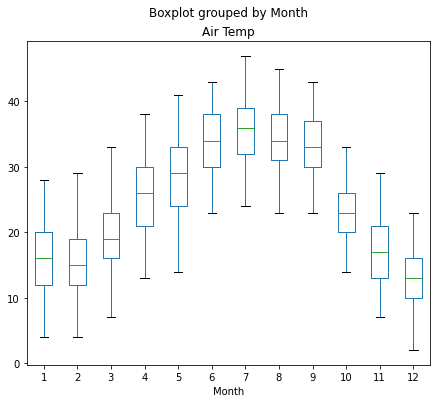

In [20]:
baseline_df.boxplot(by ='Month', column =['Air Temp'], grid = False, figsize = (7, 6))

There is no outliers for air temperature

<AxesSubplot:title={'center':'Rel Humid'}, xlabel='Month'>

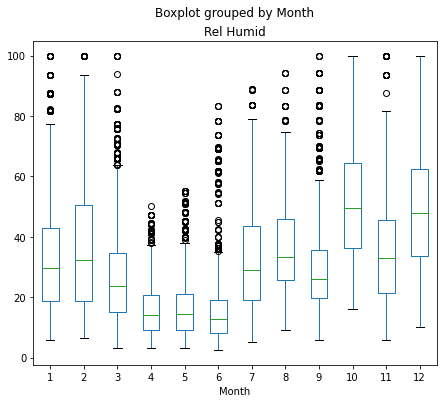

In [21]:
baseline_df.boxplot(by ='Month', column =['Rel Humid'], grid = False, figsize = (7, 6))

### 5.1.2 For CHWTON data

<function matplotlib.pyplot.show(close=None, block=None)>

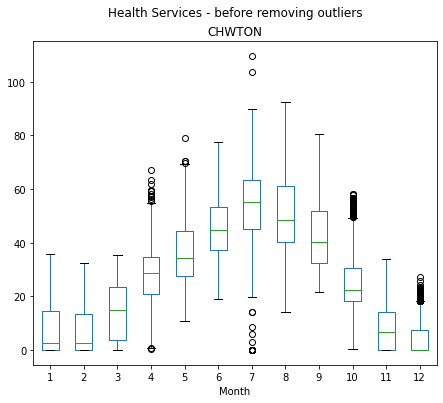

In [22]:
baseline_df.boxplot(by ='Month', column =['CHWTON'], grid = False, figsize = (7, 6))
plt.suptitle(bldname + ' - before removing outliers')
plt.show

### 5.1.3 Detect Outliers

We will use isolation Forest to detect outliers for CHWTON

numpy: 
 [[0.0000e+00 1.1000e-01]
 [1.0000e+00 1.3000e-01]
 [2.0000e+00 1.0000e-01]
 ...
 [3.4526e+04 1.0000e-02]
 [3.4527e+04 0.0000e+00]
 [3.4528e+04 1.0000e-02]] 

outliers index: 
 (array([    0,     1,     2, ..., 34526, 34527, 34528]),) 



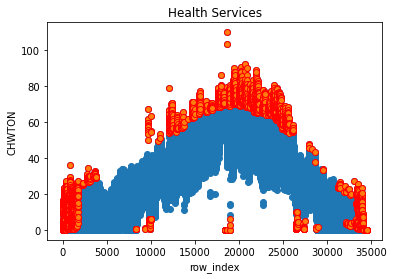

In [23]:
# 1. Get CHWTON column
x = baseline_df[['CHWTON']]

# 2. Use row number as index instead of dates
x = x.reset_index(drop = True)
x['index'] = x.index
x = x[['index','CHWTON']]

# 3. Convert as numpy
x = x.values
print('numpy: \n', x, '\n')

# 4. Create iForest model and train
iForestModel = IsolationForest(contamination=.1)
iForestModel.fit(x)

# 5. Get outliers detection (-1 means outliers). The result is a numpy 
outliers_prediction = iForestModel.predict(x)

# 6. Get indices of the outliers.
# it's a tuplel
outliers_index = np.where(outliers_prediction < 0)
print('outliers index: \n', outliers_index,'\n')

# 7. Get outliers prediction as df so we can remove it
outliers_df = pd.DataFrame({'dropIndex':outliers_prediction})

# 8. Plot
plt.scatter(x[:,0], x[:,1])
plt.scatter(x[outliers_index,0], x[outliers_index,1], edgecolors='r')
plt.title(bldname)
plt.xlabel("row_index")
plt.ylabel("CHWTON")
plt.show()

### 5.1.4 Remove Outliers

In [24]:
# 1. Reset Index so we can merge outliers and original data on index
baseline_df_reset_index = baseline_df.reset_index()

# 2. Merge outliers data and original data
baseline_df_reset_index = pd.merge(baseline_df_reset_index, outliers_df, left_index = True, right_index = True)

# 3. Remove outliers
baseline_df_outl_removed = baseline_df_reset_index[baseline_df_reset_index .dropIndex == 1]
baseline_df_outl_removed

# 4. Remove dropIndex Column
baseline_df_outl_removed.drop(columns = ['dropIndex'], inplace = True)

/Users/sherlyhartono/opt/anaconda3/envs/myConda/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
baseline_df_outl_removed

,index,Month,Day,Hour,Minute,Air Temp,Rel Humid,KW,CHWTON
5,01/01/2018 01:15,1,1,1,15,9.0,46.00,33.60,0.01
6,01/01/2018 01:30,1,1,1,30,9.0,46.00,33.61,0.00
7,01/01/2018 01:45,1,1,1,45,9.0,46.00,34.13,0.00
9,01/01/2018 02:15,1,1,2,15,9.0,46.00,33.29,0.01
10,01/01/2018 02:30,1,1,2,30,8.0,49.22,34.13,0.01
...,...,...,...,...,...,...,...,...,...
34512,12/31/2018 19:00,12,31,19,0,6.0,100.00,76.71,0.03
34515,12/31/2018 19:45,12,31,19,45,5.0,100.00,69.80,0.03
34518,12/31/2018 20:30,12,31,20,30,6.0,93.30,63.55,0.03
34519,12/31/2018 20:45,12,31,20,45,6.0,93.30,66.35,0.03


<function matplotlib.pyplot.show(close=None, block=None)>

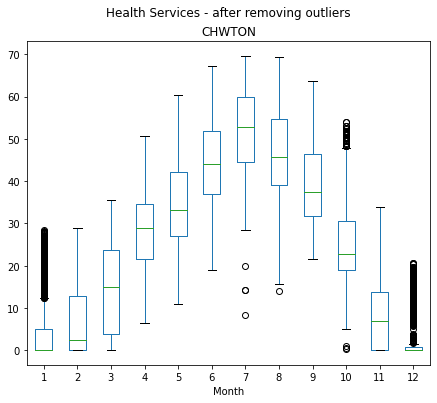

In [26]:
baseline_df_outl_removed.boxplot(by ='Month', column =['CHWTON'], grid = False, figsize = (7, 6))
plt.suptitle(bldname + ' - after removing outliers')
plt.show

In [27]:
# put back our date as index
baseline_df = baseline_df_outl_removed
baseline_df.set_index('index', inplace = True)

## 5.2 Correlation Matrix

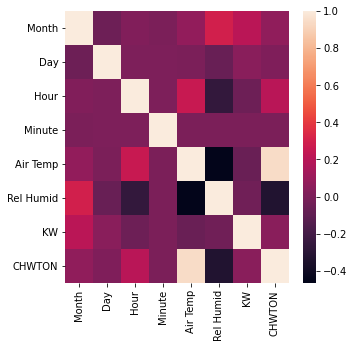

In [28]:
corrMatrix = baseline_df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corrMatrix)
plt.show()

## 5.3 Multicolinearity

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable. An acceptable VIF is if it’s less than the max of 10

In [29]:
## Get X and Y
Y = baseline_df['CHWTON']
X = baseline_df.drop(labels = ['CHWTON'], axis = 1)

X_int = X.copy(deep = True)

vif_data = pd.DataFrame()
vif_data["feature"] = X_int.columns
vif_data["VIF"] = [variance_inflation_factor(X_int.values, i) for i in range(len(X_int.columns))]

vif_data

,feature,VIF
0,Month,5.955928
1,Day,3.923535
2,Hour,3.636055
3,Minute,2.690088
4,Air Temp,7.470538
5,Rel Humid,3.726968
6,KW,10.561556


# 6. Model 1: Random Forest

Scoring:
One one hand, RMSE tells us the typical distance between the predicted value made by the regression model and the actual value.

On the other hand, R2 tells us how well the predictor variables can explain the variation in the response variable.

## 6.1 Train Test (all year)

In [30]:
############################ RANDOM FORESTS #################################3
# 1. import library
from sklearn.model_selection import train_test_split

# 1. Split into train test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# 2. Set up model. Number of trees 100
base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

# 3. Train data
base_RF.fit(X_train, Y_train)

# 4. Get prediction
Y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual CHWTON':Y_test, 'Predicted CHWTON':Y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

                  Actual CHWTON  Predicted CHWTON
index                                            
01/01/2018 05:00           0.01            0.0098
01/01/2018 07:00           0.01            0.0122
01/01/2018 23:45           0.02            0.0313
01/02/2018 02:30           0.02            0.0228
01/02/2018 02:45           0.02            0.0222
...                         ...               ...
12/31/2018 06:30           0.03            0.0206
12/31/2018 11:00           0.03            0.0284
12/31/2018 12:45           0.03            0.0313
12/31/2018 18:30           0.03            0.0309
12/31/2018 18:45           0.03            0.0298

[6216 rows x 2 columns]


In [31]:
# Custom functions for scoring
# 1. This function will returns R2 and RMSE score given a model and X, Y tests data
def evaluate(model, X_tests, Y_tests):
    Y_preds = model.predict(X_tests)
    R2 = model.score(X_tests, Y_tests)
    RMSE = np.sqrt(metrics.mean_squared_error(Y_tests, Y_preds))
    return [R2, RMSE]

# 2. This function will append a new all year score (row) to our scores data frame
def append_all_year_score(dataframe, score_list, model_name):
    i = dataframe.shape[0] # new index
    dataframe.loc[ i, ('model','') ] = model_name
    dataframe.loc[ i, ('all_year','R2') ] = score_list[0]
    dataframe.loc[ i, ('all_year','RMSE') ] = score_list[1]
    return dataframe

# 3. This function will append a new June 9th score (column) to our scores data frame of the last row
def append_j9_score(dataframe, score_list, isEnvimet = False):
    # 1. Check which baseline model we used
    data_name = 'baseline'
    if(isEnvimet == True):
        data_name = 'envimet'
    
    # 2. get last index
    i = dataframe.shape[0] - 1 
    
    # 3.  add scores to the last index
    dataframe.loc[i, (data_name, 'R2')] = score_list[0]
    dataframe.loc[i, (data_name, 'RMSE')] = score_list[1]

    return dataframe


# 4. This function will append all scores to score df
# it will call evaluate(), append_all_year_score(), and append_j9_score() above
def get_model_score_df(pModel, pX_test, pY_test, pX_j9, pX_j9_envi, pY_j9, pScore_df, pModel_name):
    # 1. all year 
    all_year_score = evaluate(pModel, pX_test, pY_test) # evaluate
    pScore_df = append_all_year_score(pScore_df, all_year_score, pModel_name) # append to score_df
    # 2. weather station
    weather_st_score = evaluate(pModel, pX_j9, pY_j9) # evaluate
    pScore_df = append_j9_score(pScore_df, weather_st_score, isEnvimet = False)  # append to score_df
    
    # 3. envimet
    envimet_score = evaluate(pModel, pX_j9_envi, pY_j9) # evaluate
    pScore_df = append_j9_score(pScore_df, envimet_score, isEnvimet = True) # append to score_df

    return pScore_df


In [32]:
# 1. get score
r2rmse = evaluate(base_RF, X_test, Y_test)

# 2. create score df
arrays = [["all_year", "all_year"],['R2', 'RMSE']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)
scores_df = pd.DataFrame([[2,1]], columns=index)

# 3. fill model name and score
scores_df['model'] = 'base RF'
scores_df['all_year', 'R2'] = r2rmse[0]
scores_df['all_year', 'RMSE'] = r2rmse[1]
scores_df = scores_df[['model', 'all_year']]
scores_df


model  all_year          
                  R2      RMSE
0  base RF  0.986082  2.264813

In [33]:
# Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(base_RF.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")


Feature Importances:
Air Temp     0.899805
Rel Humid    0.037984
KW           0.029998
Month        0.015491
Day          0.009250
Hour         0.006243
Minute       0.001228
dtype: float64 



## 6.2 June 9th Prediction

### Baseline

In [34]:
# 1. Get X and Y (all test)
X_j9 = baseline_j9.drop(labels = ['CHWTON'], axis = 1)
Y_j9 = baseline_j9['CHWTON']

# 2. calc scores 
base_score = evaluate(base_RF, X_j9, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, base_score, isEnvimet = False)

### Microclimate

In [35]:
# 1. Get X and Y (all test)
X_j9_envi = envimet_j9.drop(labels = ['CHWTON'], axis = 1)

# 2. calc scores 
base_score = evaluate(base_RF, X_j9_envi, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, base_score, isEnvimet = True)
scores_df

model  all_year           baseline             envimet          
                  R2      RMSE       R2      RMSE        R2      RMSE
0  base RF  0.986082  2.264813  0.96584  2.142106  0.887648  3.884857

## 6.3 RF using Randomized Search

### Set parameters grid

In [36]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True, False]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### Train, Test, Score

In [ ]:
# Use the random grid to search for best hyperparameters
# 1.Create the base model to tune
rf = RandomForestRegressor(random_state = 42)

# 2. Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 3. Fit the random search model
rf_random.fit(X_train, Y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(rf_random.best_estimator_.get_params())
pprint(rf_random.best_score_)

# 5. get the best model
random_RF = rf_random.best_estimator_

# 6. get all score as df
scores_df = get_model_score_df(random_RF,
                               X_test, Y_test,
                               X_j9, X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random RF')    

scores_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


# 7. Model 2: Catboost

## 7.1 Catboost Grid Search

In [ ]:
# 1. initialize model and grid
catboost = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'depth': [2, 4, 8, 10],
        'iterations': [50, 100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5]}


# 2. search parameter
train_dataset = cb.Pool(X_train, Y_train) 
test_dataset = cb.Pool(X_test, Y_test)
result = catboost.grid_search(grid,
                           train_dataset,
                           cv = 5,
                           search_by_train_test_split=True,
                           shuffle = True,
                           refit = True,
                           verbose = True,
                           train_size = 0.8 )


# 3. get best params
best_params = result['params']

# 4. fit model with best params
grid_CB = cb.CatBoostRegressor(depth = best_params['depth'],
                               iterations = best_params['iterations'],
                               learning_rate= best_params['learning_rate'],
                               l2_leaf_reg = best_params['l2_leaf_reg'])
grid_CB.fit(train_dataset)

# 5. get score as df
scores_df = get_model_score_df(grid_CB,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'grid CB')    


## 7.2 Catboost Random Search

In [ ]:
# catboost = cb.CatBoostRegressor(loss_function='RMSE', random_state = 42)

# 1. hyperparameter grid
cb_grid = {'iterations': [50, 100, 150, 200, 250],
            'learning_rate': [0.03, 0.1],
            'depth': [2, 4, 8, 10, 12],
            'l2_leaf_reg': [0.2, 0.5, 1, 3, 5, 7]}

# 2. instantiate RandomSearchCv object
catboost_random = RandomizedSearchCV(estimator = catboost,
                               param_distributions = cb_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)


# 3. Fit the model
catboost_random.fit(X_train,Y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(catboost_random.best_estimator_.get_params())
pprint(catboost_random.best_score_)

# 5. get the best model
random_CB = catboost_random.best_estimator_

# 6. get score
scores_df = get_model_score_df(random_CB,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random CB')    


In [ ]:
print(bldname)
scores_df

# 8. Model 3: Adaboost

In [ ]:

adaboost = AdaBoostRegressor(random_state = 42)


# 1. hyperparameter grid
adaBoost_params = {'learning_rate':[0.05,0.1,0.2,0.6,0.8,1],
                   'n_estimators': [50,60,100],
                   'loss' : ['linear', 'square', 'exponential']}

# 2. instantiate RandomSearchCv object
adaboost_random = RandomizedSearchCV(adaboost,
                                     param_distributions=adaBoost_params,
                                     n_iter = 100,
                                     scoring ='r2',
                                     random_state = 42,
                                     n_jobs = -1)

# 3. Fit the model
adaboost_random.fit(X_train,Y_train)

# 4. print winning set of hyperparameters
pprint(adaboost_random.best_estimator_.get_params())
pprint(adaboost_random.best_score_)

# 5. get the best model
random_ADA = adaboost_random.best_estimator_

# 6. get score
scores_df = get_model_score_df(random_ADA,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random ADA')


In [ ]:
print(bldname)
scores_df

# 9. Model 4: XGboost

In [ ]:
# 2. create an xgboost regression model
XGB = XGBRegressor(n_estimators = 1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# 3. Train
XGB.fit(X_train, Y_train)

# 4. Predict
R2non = XGB.score(X_test, Y_test)

# 5. Score
R2non = XGB.score(X_test, Y_test)
print('R2 non-cyclical: ', R2non)

## 9.1 XGB Random Search

In [ ]:
# 1. Hyperparameter grid
params = {
    'n_estimators':[ 250, 500, 1000],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

reg = XGBRegressor()

n_iter_search = 20

# 2. instantiate RandomSearchCv object
xgb_random = RandomizedSearchCV(reg,
                                param_distributions = params,
                                n_iter = n_iter_search,
                                cv = 5,
                                verbose = 2,
                                random_state = 42,
                                scoring ='r2',
                                n_jobs = -1)


# 3. Fit the model
xgb_random.fit(X_train, Y_train)

# 4. get the best model
xgb_best = xgb_random.best_estimator_

# 5. get score
scores_df = get_model_score_df(xgb_random,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random XGB')

scores_df

# 10. Model 5: LightGBM

# 11. Save Scores

In [ ]:
import os
scores_df['bld_name'] = bldname
scores_df = scores_df[['bld_name', 'model', 'all_year', 'baseline', 'envimet']]
scores_df


In [ ]:
if(base_name == 'station'):
    pathname = './Data/scores.csv'
else:
    pathname = './Data/scores_asu.csv'

In [ ]:
# 1. if file does not exist write header 
if not os.path.isfile(pathname):
    scores_df.to_csv(pathname, header='column_names')
else: # 2. else it exists so append without writing the header
    with open(pathname,'a') as f:
        
        f.write('\n')  # 4. got to next line before writing
    # 5. write:
    scores_df.to_csv(pathname, index = True, header = False, mode='a')

# 12. Get prediction of best model

In [ ]:
# 1. get best model ( get max of score_df all year)
best_model = grid_CB

# 2. get weather station prediction
Y_pred_j9 = best_model.predict(X_j9)

# 3. get envimet prediction
Y_pred_j9_envi = best_model.predict(X_j9_envi)

# 4. show predictions
Pred = pd.DataFrame({'Actual':Y_j9,'Baseline Predictions (AZW)': Y_pred_j9, 'Microclimate Predictions': Y_pred_j9_envi})
Pred

# 13. Hypothesis Test

In [ ]:
# plt.boxplot([Y_pred_j9, Y_pred_j9_envi])
# plt.xticks([1,2],['Baseline_pred', 'Microclimate_pred'])
# print(Y_pred_j9.mean())
# print(Y_pred_j9_envi.mean())
# print('mu:', Y_pred_j9.mean()- Y_pred_j9_envi.mean())

## Two-Sample T Test


mean differences in CHWTON = $ \mu_{baseline} - \mu_{microclimate}$ 

$ H_0: $ Mean of CHWTON in baseline and microclimate are the same

$ H_1: $ Mean of CHWTON in baseline and microclimate are NOT the same

## 13.1 calculate standard deviation

In [ ]:
# # 1.variance
# var_baseline = Y_pred_j9.var(ddof = 1)
# var_micro = Y_pred_j9_envi.var(ddof = 1)
# print('var:',var_baseline, var_micro)

# # 2. standard deviation
# s = np.sqrt((var_baseline + var_micro)/2)
# print('s:',s)

## 13.2 calculate T-statistic

In [ ]:
# import scipy.stats as stats
# t_stat, p_val = stats.ttest_ind(Y_pred_j9, Y_pred_j9_envi, equal_var=False)
# print('t statistics: ', t_stat)
# print('p value: ', p_val)

P value is not less that 0.05. We cannot reject the null hypothesis. There is no significant difference between the transaction amount of fraud and non fraudulent transaction

# 14. Plot

In [ ]:
####### Plotting Baseline Model for all 2018 15-min Data #######

## This is a big graph, will be slow to run but gives visual of prediction accuracy
# %matplotlib qt
plt.xlabel('Baseline 15-Min Model')
plt.ylabel('CHWTON')
plt.plot(ModelPred['Actual CHWTON'], label = 'Actual CHWT')
plt.plot(ModelPred['Predicted CHWTON'], label = 'Predicted CHWT')
plt.legend()
plt.show()

In [ ]:
#  Plotting ENVI-met vs AZW vs Actual Data for June 9 from 5a - 8p
positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
labels = ['5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p']

# plot EnviMet vs AZ_Weather results
plt.xlabel('Time 5a - 8p')
plt.ylabel('CHWTON')
plt.xticks(positions, labels)
plt.plot(Pred['Microclimate Predictions'], label = 'ENVIMET Prediction')
plt.plot(Pred['Baseline Predictions (AZW)'], label = 'Baseline Prediction')
plt.plot(Pred['Actual'], label = 'Actual Data')
plt.title(bldname)
plt.legend()

## show graphs
plt.show()